# Task2: Time Series Forecasting Models

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install -q yfinance pandas_datareader pmdarima

In [27]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pmdarima as pm
import math
import  math, time, pathlib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# load saved data (prices/returns/meta)

In [28]:
plt.rcParams["figure.figsize"] = (10,4)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

# Try common paths: adjust if you saved elsewhere
CANDIDATE_DIRS = ["/content/drive/MyDrive/preprocessed_data"]
def find_file(name):
    for d in CANDIDATE_DIRS:
        p = os.path.join(d, name)
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"Could not find {name} in {CANDIDATE_DIRS}")

prices_path = find_file("prices.csv")
returns_path = os.path.join(os.path.dirname(prices_path), "returns.csv") if os.path.exists(os.path.join(os.path.dirname(prices_path), "returns.csv")) else None
meta_path = os.path.join(os.path.dirname(prices_path), "meta.json") if os.path.exists(os.path.join(os.path.dirname(prices_path), "meta.json")) else None

close = pd.read_csv(prices_path, parse_dates=["Date"]).set_index("Date").sort_index()
if returns_path:
    rets = pd.read_csv(returns_path, parse_dates=["Date"]).set_index("Date").sort_index()
else:
    rets = np.log(close/close.shift(1)).dropna()

meta = {}
if meta_path:
    with open(meta_path) as f: meta = json.load(f)

print("Loaded:")
print("  prices:", prices_path)
print("  returns:", returns_path or "(computed)")
print("  meta:", meta_path or "(none)")
print("Window:", close.index.min().date(), "→", close.index.max().date(), "rows:", len(close))
print("Columns:", list(close.columns))
assert "TSLA" in close.columns, "TSLA column not found in prices.csv"

# quick peek
display(close.tail())


Loaded:
  prices: /content/drive/MyDrive/preprocessed_data/prices.csv
  returns: /content/drive/MyDrive/preprocessed_data/returns.csv
  meta: /content/drive/MyDrive/preprocessed_data/meta.json
Window: 2015-07-01 → 2025-07-31 rows: 2632
Columns: ['BND', 'SPY', 'TSLA']


,BND,SPY,TSLA
Date,,,
2025-07-25,73.120000,637.100000,316.060000
2025-07-28,73.000000,636.940000,325.590000
2025-07-29,73.380000,635.260000,321.200000
2025-07-30,73.190000,634.460000,319.040000
2025-07-31,73.200000,632.080000,308.270000


# split train/test (chronological)

In [29]:
SPLIT_DATE = pd.Timestamp("2024-01-01")
tsla = close["TSLA"].astype(float)

train_y = tsla.loc[tsla.index < SPLIT_DATE]
test_y  = tsla.loc[tsla.index >= SPLIT_DATE]

print("Train:", train_y.index.min().date(), "→", train_y.index.max().date(), "n=", len(train_y))
print("Test :", test_y.index.min().date(),  "→", test_y.index.max().date(),  "n=", len(test_y))

# sanity
assert len(train_y) > 200 and len(test_y) > 30


Train: 2015-07-01 → 2023-12-29 n= 2218
Test : 2024-01-01 → 2025-07-31 n= 414


# ARIMA baseline (auto_arima on prices)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2218
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7016.281
Date:                Thu, 14 Aug 2025   AIC                          14042.562
Time:                        11:23:56   BIC                          14071.081
Sample:                    07-01-2015   HQIC                         14052.979
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7595      0.012     61.410      0.000       0.735       0.784
ar.L2         -0.9211      0.014    -66.958      0.000      -0.948      -0.894
ma.L1         -0.7975      0.009    -87.903      0.0

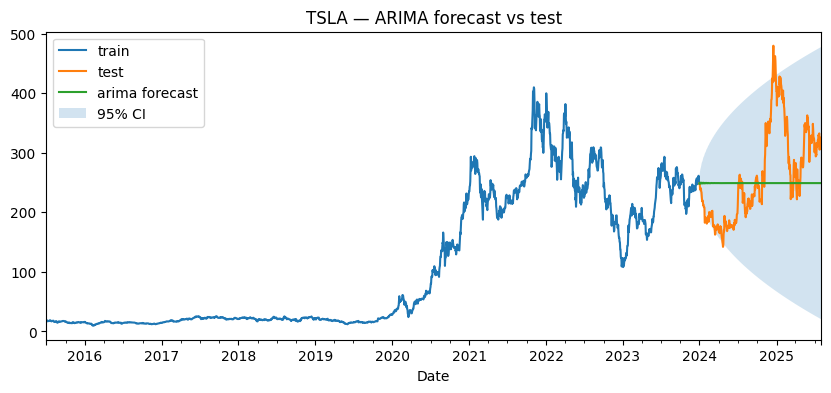

In [30]:
model_arima = pm.auto_arima(
    train_y,
    seasonal=False, stepwise=True,
    suppress_warnings=True, error_action="ignore",
    information_criterion="aic", max_p=5, max_q=5, max_d=2
)
print(model_arima.summary())

n_test = len(test_y)
fc_arima, conf = model_arima.predict(n_periods=n_test, return_conf_int=True)
fc_arima = pd.Series(fc_arima, index=test_y.index)
conf = pd.DataFrame(conf, index=test_y.index, columns=["lower","upper"])

mae_a  = mean_absolute_error(test_y, fc_arima)
rmse_a = math.sqrt(mean_squared_error(test_y, fc_arima))
mape_a = (np.abs((test_y - fc_arima)/test_y)).mean()*100
print(f"ARIMA  MAE={mae_a:.3f}  RMSE={rmse_a:.3f}  MAPE={mape_a:.2f}%")

plt.figure()
train_y.plot(label="train")
test_y.plot(label="test")
fc_arima.plot(label="arima forecast")
plt.fill_between(conf.index, conf["lower"], conf["upper"], alpha=0.2, label="95% CI")
plt.title("TSLA — ARIMA forecast vs test"); plt.legend(); plt.show()


# LSTM setup: pick backend (TensorFlow if available, else PyTorch)

In [22]:
BACKEND = None
try:
    import tensorflow as tf
    from tensorflow import keras
    BACKEND = "tf"
    print("Using TensorFlow:", tf.__version__)
except Exception:
    try:
        import torch
        import torch.nn as nn
        BACKEND = "torch"
        print("Using PyTorch:", torch.__version__)
    except Exception:
        BACKEND = None
        print("No TF or Torch detected; LSTM will be skipped.")


Using TensorFlow: 2.16.1


LSTM data prep (scaling + sliding windows)

In [23]:
# LSTM expects scaled inputs and sequence windows.
def make_windows(arr, lookback=60):
    X, y = [], []
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i, 0]); y.append(arr[i, 0])
    return np.array(X)[...,None].astype("float32"), np.array(y).astype("float32")

LOOKBACK = 60
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_y.values.reshape(-1,1))
test_scaled  = scaler.transform(test_y.values.reshape(-1,1))

Xtr, ytr = make_windows(train_scaled, LOOKBACK)

# For test windows, prepend last LOOKBACK points from train so window continuity is preserved
Xte_full, yte_full = make_windows(np.vstack([train_scaled[-LOOKBACK:], test_scaled]), LOOKBACK)

print("Shapes → Xtr:", Xtr.shape, "ytr:", ytr.shape, "Xte_full:", Xte_full.shape, "yte_full:", yte_full.shape)


Shapes → Xtr: (2158, 60, 1) ytr: (2158,) Xte_full: (414, 60, 1) yte_full: (414,)


# LSTM (TensorFlow path)

LSTM (TF)  MAE=14.586  RMSE=20.052  MAPE=5.42%


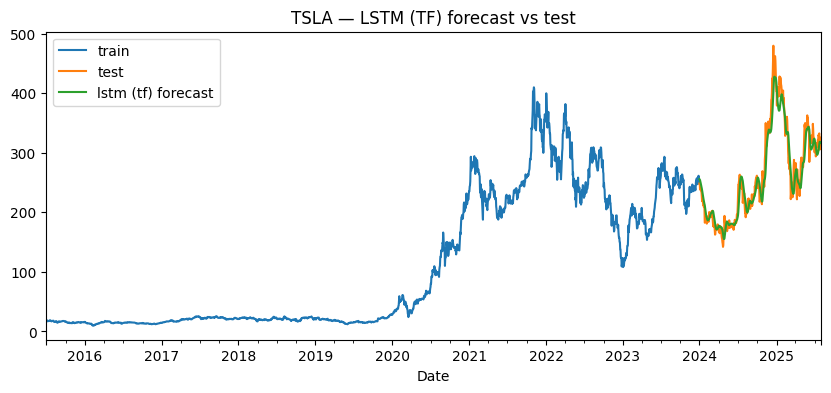

In [24]:
# A small, stable LSTM: two layers + dropout, trained with MSE.
if BACKEND == "tf":
    from tensorflow import keras

    model = keras.Sequential([
        keras.layers.Input(shape=(LOOKBACK,1)),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(32),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    _ = model.fit(Xtr, ytr, epochs=15, batch_size=64, verbose=0)

    # Predict for the combined test windows, then align to test index
    pred_scaled = model.predict(Xte_full, verbose=0).reshape(-1,1)
    pred = scaler.inverse_transform(pred_scaled).ravel()
    fc_lstm = pd.Series(pred[-len(test_y):], index=test_y.index)

    # Metrics
    mae_l  = mean_absolute_error(test_y, fc_lstm)
    rmse_l = math.sqrt(mean_squared_error(test_y, fc_lstm))
    mape_l = (np.abs((test_y - fc_lstm)/test_y)).mean()*100
    print(f"LSTM (TF)  MAE={mae_l:.3f}  RMSE={rmse_l:.3f}  MAPE={mape_l:.2f}%")

    # Plot
    plt.figure()
    train_y.plot(label="train")
    test_y.plot(label="test")
    fc_lstm.plot(label="lstm (tf) forecast")
    plt.title("TSLA — LSTM (TF) forecast vs test")
    plt.legend(); plt.show()


# comparing & selecting model for Task 3

In [17]:
def safe(x):
    try: return float(x)
    except: return np.nan

print("== Model comparison (lower is better) ==")
print(f"ARIMA: MAE={mae_a:.3f}, RMSE={rmse_a:.3f}, MAPE={mape_a:.2f}%")

if 'mae_l' in globals():
    print(f"LSTM : MAE={mae_l:.3f}, RMSE={rmse_l:.3f}, MAPE={mape_l:.2f}%")
    choice = "ARIMA" if safe(rmse_a) <= safe(rmse_l) else "LSTM"
else:
    print("LSTM : (skipped — backend not available)")
    choice = "ARIMA"

print(f"\nChosen for Task 3 forecasts: {choice}")


== Model comparison (lower is better) ==
ARIMA: MAE=63.734, RMSE=78.869, MAPE=24.22%
LSTM : MAE=15.132, RMSE=19.305, MAPE=5.99%

Chosen for Task 3 forecasts: LSTM


# Save summary + ARIMA + (TF LSTM + scaler) for Task 3

In [34]:
import os, json, pickle
os.makedirs("models", exist_ok=True)

# Summary / provenance
artifact = {
    "chosen_model": str(choice),                  # "LSTM" or "ARIMA"
    "split_date": str(SPLIT_DATE.date()),
    "metrics": {
        "arima": {"MAE": float(mae_a), "RMSE": float(rmse_a), "MAPE": float(mape_a)},
        "lstm": (
            {"MAE": float(mae_l), "RMSE": float(rmse_l), "MAPE": float(mape_l),
             "backend": BACKEND, "lookback": int(LOOKBACK) if 'LOOKBACK' in globals() else None}
            if 'mae_l' in globals() else None
        ),
    },
    "provenance": meta if 'meta' in globals() else {},
}
with open("models/summary.json", "w") as f:
    json.dump(artifact, f, indent=2)
print(" Wrote models/summary.json")

#  ARIMA model
with open("models/tsla_arima.pkl", "wb") as f:
    pickle.dump(model_arima, f)
print(" Wrote models/tsla_arima.pkl")

#  LSTM (TensorFlow) + scaler
if 'BACKEND' in globals() and BACKEND == 'tf' and 'mae_l' in globals():
    # Save scaler (needed to invert to price space)
    with open("models/tsla_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    print(" Wrote models/tsla_scaler.pkl")

    # Prefer the new Keras format file; if not allowed, export SavedModel directory
    keras_path = "models/tsla_lstm_tf.keras"
    try:
        model.save(keras_path)          # Keras 3/TF 2.16+ recommended format
        print(f" Wrote {keras_path}")
    except ValueError:
        # Fallback: export a SavedModel directory (e.g., for TF Serving/TFLite)
        model.export("models/tsla_lstm_tf")  # directory
        print(" Exported models/tsla_lstm_tf (SavedModel directory)")
else:
    print(" Skipped saving TF LSTM artifacts (TF backend not active or LSTM not run).")


 Wrote models/summary.json
 Wrote models/tsla_arima.pkl
 Wrote models/tsla_scaler.pkl
 Wrote models/tsla_lstm_tf.keras
